In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import lettuce as lt
from lettuce import D2Q9, Lattice, UnitConversion, BGKCollision, StandardStreaming, Simulation, IncompressibleKineticEnergy
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter


In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolutionx", type=int, default=80)
parser.add_argument("--resolutiony", type=int, default=40)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=100)
parser.add_argument("--tmax", type=int, default=20)
parser.add_argument("--Re", type=int, default=5000)
parser.add_argument("--collision_operator", type=str, default="BGK")
parser.add_argument("--Precision", type=str, default="Single")
parser.add_argument("--Mach", type=float, default=0.1)
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision= args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
res_x = args["resolutionx"]
res_y = args["resolutiony"]

acceleration = np.array([1e-5, 0.0])  # Body Force in x-Richtung (Guo)


if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16

ICH FUNKTIONIERE MIT PULLEN


steps     time     IncompressibleKineticEnergy
tensor([[[-2.9800e-06,  4.1259e-03,  1.2177e-02,  ...,  1.1960e-02,
           4.0044e-03, -8.3810e-07],
         [-2.9278e-06,  4.1236e-03,  1.2172e-02,  ...,  1.1964e-02,
           4.0062e-03, -7.6732e-07],
         [-3.1327e-06,  4.1210e-03,  1.2167e-02,  ...,  1.1969e-02,
           4.0089e-03, -9.0142e-07],
         ...,
         [-3.1513e-06,  4.1301e-03,  1.2185e-02,  ...,  1.1951e-02,
           3.9992e-03, -6.7234e-07],
         [-3.2817e-06,  4.1290e-03,  1.2182e-02,  ...,  1.1953e-02,
           4.0011e-03, -3.9856e-07],
         [-3.1234e-06,  4.1277e-03,  1.2180e-02,  ...,  1.1956e-02,
           4.0023e-03, -6.5185e-07]],

        [[ 8.3011e-05, -4.1591e-06, -8.4205e-06,  ..., -7.4177e-06,
          -4.0243e-06, -1.1206e-04],
         [ 8.0862e-05, -5.2073e-06, -1.0132e-05,  ..., -9.3627e-06,
          -5.0760e-06, -1.1419e-04],
         [ 7.8806e-05, -6.3188e-06, -1.1629e-05,  ..., -1.0839e-05,
          -5.3011e-06, -1.163

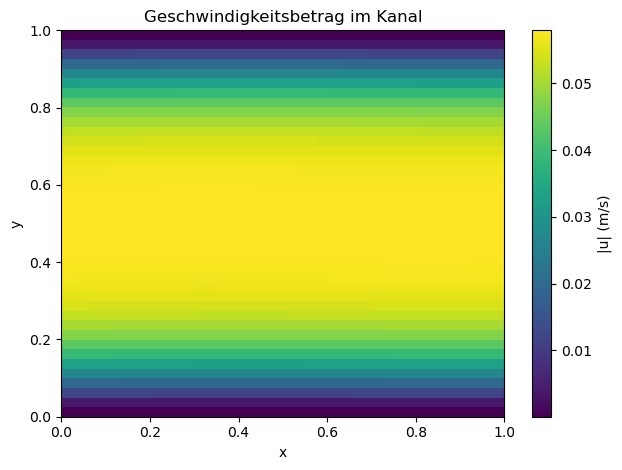

In [3]:

# --- 🧱 Lattice & Einheiten ---
lattice = Lattice(D2Q9, device="cpu", dtype=dtype)

flow = lt.ChannelFlow2D(
    resolution_x=res_x,
    resolution_y=res_y,
    reynolds_number=Re,
    mach_number=Mach,
    lattice=lattice,
    char_length_lu=res_y
)

# --- 🧱 Wände definieren ---
x, y = flow.grid  # physikalische Gitterkoordinaten

# y in LU umrechnen (nur nötig, falls du nach physikalischen Einheiten schneiden willst)
# Hier reicht aber die Indexierung direkt, da wir die äußersten Zeilen meinen:
mask = np.zeros_like(x, dtype=bool)
mask[:, 0] = True           # untere Wand (y=0)
mask[:, -1] = True          # obere Wand (y=max)

# Maske setzen
flow.mask = mask

# --- 🌀 Forcing (Guo) ---
from lettuce.force import Guo  # dein Guo-Code
forcing = Guo(lattice, tau=flow.units.relaxation_parameter_lu, acceleration=acceleration)

# --- 🔁 Setup Simulation ---
if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=round(flow.units.relaxation_parameter_lu,7))
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)

streaming = StandardStreaming(lattice)
simulation = Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)

# --- 📊 Beobachter ---
Energy = IncompressibleKineticEnergy(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=100, out=None)
simulation.reporters.append(reporter)

vtk_reporter = lt.VTKReporter(
    lattice=lattice,
    flow=flow,
    interval=100,                    # alle 100 Zeitschritte ein VTK-Frame
    filename_base=basedir + "/output" # Basisname der Dateien
)
simulation.reporters.append(vtk_reporter)


# --- ▶️ Simulation starten ---
steps = int(flow.units.convert_time_to_lu(50))  # z.B. 5 Sekunden
mlups = simulation.step(num_steps=steps)
# --- 📈 Analyse ---
u = lattice.u(simulation.f) # u-Komponente
u_mean= torch.mean(u, dim=(1,0))

print(u) # Mittelung über x-Richtung

# Hole u_x-Komponente (Index 0)
u_numpy = u.cpu().numpy()  # [2, res_x, res_y]
u_mag = np.sqrt(u_numpy[0]**2 + u_numpy[1]**2)  # Geschwindigkeitbetrag

plt.imshow(u_mag.T, origin='lower', extent=[0, 1, 0, 1], aspect='auto')
plt.colorbar(label='|u| (m/s)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Geschwindigkeitsbetrag im Kanal")
plt.tight_layout()
plt.show()
